In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import numpy as np
import pandas as pd
from glob import glob
import cv2
import timm
import random
import time

# GPU 이용가능한 리눅스 환경인 경우 tsnecuda, 그렇지 않은 경우 sklearn 사용
# from tsnecuda import TSNE 
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score

from torchvision.models import wide_resnet50_2
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from collections import defaultdict

In [2]:
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-3
    epochs = 25
    batch_size = 32
    num_workers = 4
    train_5_folds = True

In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything(config.seed)

In [4]:
df = pd.read_csv('./train_df.csv')
df.head()

,index,file_name,class,state,label
0,0,10000.png,transistor,good,transistor-good
1,1,10001.png,capsule,good,capsule-good
2,2,10002.png,transistor,good,transistor-good
3,3,10003.png,wood,good,wood-good
4,4,10004.png,bottle,good,bottle-good


In [45]:
df_good = df[df['state']=='good']

In [41]:
df_notgood = df[df['state']!='good']

In [5]:
uniqeu_states_dict = {val:idx for idx,val in enumerate(df['state'].unique())}
uniqeu_classes_dict = {val:idx for idx,val in enumerate(df['class'].unique())}
uniqeu_labels_dict = {val:idx for idx,val in enumerate(df['label'].unique())}
states_cnt_dict = defaultdict(int)
classes_cnt_dict = defaultdict(int)
labels_cnt_dict = defaultdict(int)
train_dirs = sorted(glob('./train/*.png'))

In [6]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (512, 512))
    return img

In [7]:
train_imgs,states,classes,labels = [],[],[],[]
for i in range(len(df)):
    train_imgs.append(img_load(train_dirs[i]))
    states.append(uniqeu_states_dict[df['state'][i]])
    classes.append(uniqeu_classes_dict[df['class'][i]])
    labels.append(uniqeu_labels_dict[df['label'][i]])
    states_cnt_dict[df['state'][i]]+=1
    classes_cnt_dict[df['class'][i]]+=1
    labels_cnt_dict[df['label'][i]]+=1

In [32]:
sorted(states_cnt_dict.values())[:15]

[5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8]

In [31]:
sorted(states_cnt_dict.values())[-15:]

[15, 16, 16, 17, 19, 20, 21, 22, 23, 28, 29, 43, 47, 48, 3629]

In [27]:
sorted(labels_cnt_dict.values())[:25]

[4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 8, 8]

In [37]:
sorted(labels_cnt_dict.values())[-16:]

[15, 60, 209, 213, 219, 220, 224, 230, 240, 245, 247, 264, 267, 280, 320, 391]

In [39]:
for key,val in labels_cnt_dict.items():
    if val==4:
        print(key)
        break

wood-color


In [40]:
classes_cnt_dict['wood']

278

In [38]:
sorted(classes_cnt_dict.values())

[75, 233, 241, 268, 271, 273, 275, 278, 293, 294, 301, 327, 340, 381, 427]

In [66]:
y_order = list(classes_cnt_dict.keys())

이상치가 존재하는 데이터와 정상 데이터간의 개수 차이가 큼

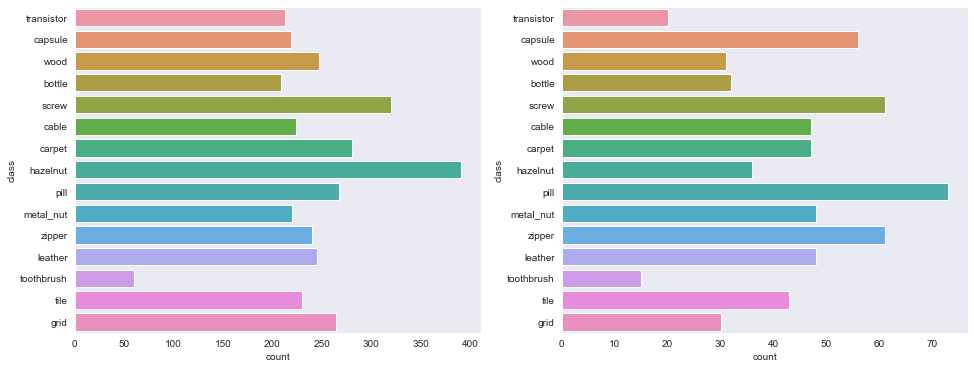

In [75]:
f = plt.figure(figsize=(16, 6))# sharex=True, sharey=True)
sns.set_style('dark')

ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)
sns.countplot(y='class',order=y_order, data=df_good, ax=ax1)
sns.countplot(y='class',order=y_order, data=df_notgood, ax=ax2)
plt.show()

각각의 state 개수도 차이가 큼

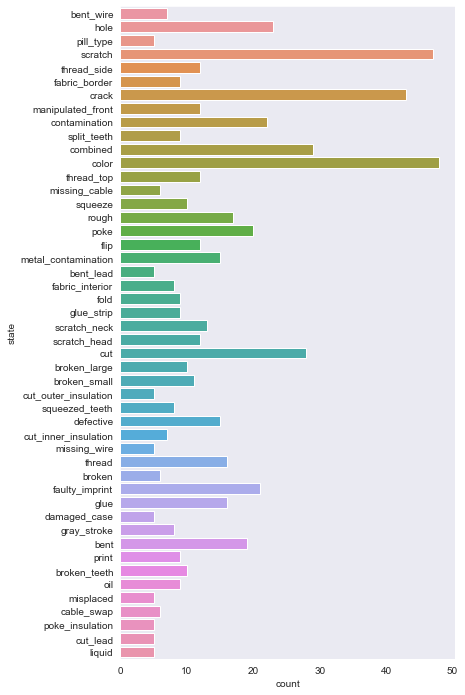

In [76]:
f, ax = plt.subplots(figsize=(6, 12))
ax = sns.countplot(y='state', data=df_notgood)

라벨 단위로 넘어오니 최소 4개, 대부분 5~8개 사이로 동일 라벨 개수가 분포함 

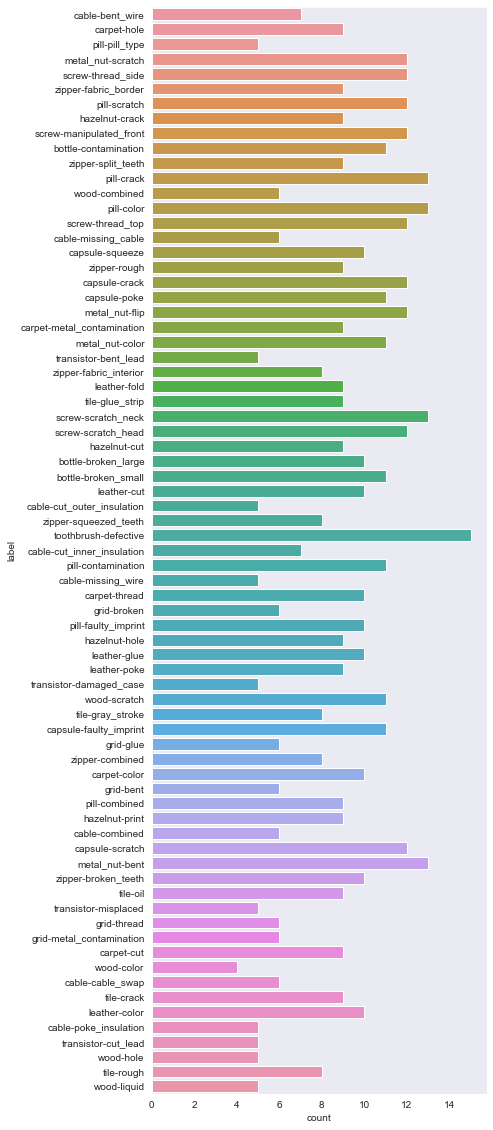

In [77]:
f, ax = plt.subplots(figsize=(6, 20))
ax = sns.countplot(y='label', data=df_notgood)